In [1]:
from pypownet.environment import RunEnv
from pypownet.agent import Agent
import logging
import logging.handlers
import threading
import queue

LOG_FILENAME = 'runner.log'


class TimestepTimeout(Exception):
    pass


class RunnerPerso(object):
    def __init__(self, environment, agent, render=False, verbose=False, vverbose=False, log_filepath='runner.log'):
        # Sanity checks: both environment and agent should inherit resp. RunEnv and Agent
        assert isinstance(environment, RunEnv)
        assert isinstance(agent, Agent)

        # Loggger part
        self.logger = logging.getLogger('pypownet')

        # Always create a log file for runners
        fh = logging.FileHandler(filename=log_filepath, mode='w+')
        fh.setLevel(logging.DEBUG)
        fh.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
        self.logger.addHandler(fh)

        if verbose or vverbose:
            # create console handler, set level to debug, create formatter
            ch = logging.StreamHandler()
            ch.setLevel(logging.DEBUG if vverbose and verbose else logging.INFO)
            ch.setFormatter(logging.Formatter('%(levelname)s        %(message)s'))
            self.ch = ch
            # add ch to logger
            self.logger.addHandler(ch)
            self.logger.setLevel(logging.DEBUG if vverbose else logging.INFO)

        self.environment = environment
        self.agent = agent
        self.verbose = verbose
        self.render = render

        # First observation given by the environment
        self.last_observation = self.environment._get_obs()

        self.max_seconds_per_timestep = self.environment.game.get_max_seconds_per_timestep()

        if self.render:
            self.environment.render()

    def step(self):
        # Policy inference
        # def agent_inference(obs, q):
        #     action = self.agent.act(obs)
        #     q.put(action)
        # q = queue.Queue()
        # t = threading.Thread(target=agent_inference, name='AgentActThread', args=(self.last_observation, q))
        # t.start()
        # t.join(self.max_seconds_per_timestep)
        # if t.is_alive():
        #     self.logger.warn('\b\b\bTook too much time to compute action for current timestep: allowed at most %s '
        #                      'seconds; emulating do-nothing action' % str(self.max_seconds_per_timestep))
        #     action = self.environment.action_space.get_do_nothing_action()
        # else:
        #     action = q.get()

        action = self.agent.act(self.last_observation)

        # Update the environment with the chosen action
        observation, reward_aslist, done, info = self.environment.step(action, do_sum=False)
        if done:
            self.logger.warn('\b\b\bGAME OVER! Resetting grid... (hint: %s)' % info.text)
            observation = self.environment.reset()
        elif info:
            self.logger.warn(info.text)

        reward = sum(reward_aslist)

        if self.render:
            self.environment.render()

        self.last_observation = observation

        self.agent.feed_reward(action, observation, reward_aslist)

        self.logger.debug('action: %s' % ('[%s]' % ' '.join(list(map(lambda x: str(int(x)), action.as_array())))))
        self.logger.debug('reward: {}'.format('[' + ','.join(list(map(str, reward_aslist))) + ']'))
        self.logger.debug('done: {}'.format(done))
        self.logger.debug('info: {}'.format(info if not info else info.text))
        self.logger.debug('observation: \n%s' % observation.__str__())

        return observation, action, reward

    def loop(self, iterations):
        cumul_rew = 0.0
        rewListCumul = []
        rewList = []
        for i in range(1, iterations + 1):
            (obs, act, rew) = self.step()
            cumul_rew += rew
            rewList.append(rew)
            rewListCumul.append(cumul_rew)
            self.logger.info("step %d/%d - reward: %.2f; cumulative reward: %.2f" % (i, iterations, rew, cumul_rew))
            
        # Close pygame if renderer has been used
        if self.render:
            self.environment.render()

        return cumul_rew, rewList, rewListCumul

In [2]:
model_dir = 'example_submission/'
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
input_dir = 'public_data/'
output_dir = 'output/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);
path.append(input_dir); path.append(output_dir);
get_ipython().run_line_magic('matplotlib', 'inline')
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
import seaborn as sns; sns.set()
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)



In [3]:
data_dir = 'public_data/hard'              # Change this to the directory where you put the input data
get_ipython().system('ls $data_dir*')

chronics  configuration.yaml  reference_grid.m


In [4]:
import os
import pypownet.environment
import pypownet.runner
data_dir = 'public_data'  
environment = pypownet.environment.RunEnv(parameters_folder=os.path.abspath(data_dir),
                                              game_level="hard",
                                              chronic_looping_mode='fixed', start_id=0,
                                              game_over_mode="soft")

Using custom reward signal CustomRewardSignal of file /home/thibaut/Grid/starting_kit/public_data/reward_signal.py



                     GAME PARAMETERS
    hard_overflow_coefficient: 1.0
    loadflow_backend: pypower
    loadflow_mode: AC
    max_number_loads_game_over: 6
    max_number_prods_game_over: 3
    max_seconds_per_timestep: 1.0
    n_timesteps_consecutive_soft_overflow_breaks: 10
    n_timesteps_hard_overflow_is_broken: 10
    n_timesteps_horizon_maintenance: 48
    n_timesteps_soft_overflow_is_broken: 10



In [5]:
NUMBER_ITERATIONS = 30

In [6]:
from scoring_program import libscores
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: reward


In [7]:
import time

In [8]:
from example_submission import baseline_agents

In [9]:

    
class ShittySubmission(pypownet.agent.Agent):
    def __init__(self, environment):
        super().__init__(environment)
        self.verbose = True
        
    def act(self, observation):
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space
        
        action = action_space.get_do_nothing_action() #We initialise an empty action
            
        lines_list = observation.get_lines_capacity_usage() #We monitor how charged the lines of our power network are
        
        #List containing the id of inactive lines
        turned_off = []
        
        #We store the ids of inactive lines in turned_off
        for i in range(action_space.lines_status_subaction_length - 1):
            if lines_list[i] == 0:
                turned_off.append(i)
        
        #If there are inactive lines, we choose one a random one to turn on
        if len(turned_off) > 0:
            rand_off_id = np.random.randint(len(turned_off))
            action_space.set_lines_status_switch_from_id(action=action,line_id=turned_off[rand_off_id],new_switch_value=1)
        
        #Here, if a line's charge exceeds 80% of it's capacity, we turn it off
        for i in range(action_space.lines_status_subaction_length - 1):
            if lines_list[i] > 0.8:
                action_space.set_lines_status_switch_from_id(action=action,line_id=i,new_switch_value=1)
        
        #These are testing variables, allowing us to monitor the actions we take during the steps
        """idList = np.arange(action_space.lines_status_subaction_length)
        line_status = action_space.get_lines_status_switch_from_id(action=action,line_id=idList)
        print(line_status)"""
        
        assert self.environment.action_space.verify_action_shape(action)
        
        return action


In [10]:

class Submission(pypownet.agent.Agent):
    """
    An example of a baseline controler that randomly switches the status of one random power line per timestep (if the
    random line is previously online, switch it off, otherwise switch it on).
    """

    def __init__(self, environment):
        super().__init__(environment)
        self.verbose = True

    def chooseAction(self, template, rewardRef):
        if 0 in template:
            actions = []
            for i in range(len(template)):
                test = template.copy()
                if test[i] != 1:
                    test[i] = 1
                    actions.append(test)
            rewards = []
            for act in actions:
                act = self.environment.action_space.array_to_action(act)
                rewards.append(sum(self.environment.simulate(act, do_sum = False)))
            rewards = np.asarray(rewards)
            best_index = np.argmax(rewards)
            if rewards[best_index] > rewardRef:
                return actions[best_index]
        return template

    def act(self, observation):
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space

        # Create template of action with no switch activated (do-nothing action)
        bestAction = np.zeros(action_space.action_length)
        stop = 1
        cpt = 0
        while(True):
            rew = sum(self.environment.simulate(action_space.array_to_action(bestAction), do_sum = False))
            newBestAction = self.chooseAction(bestAction,rew)
            if (np.array_equal(newBestAction,bestAction)):
                break
            bestAction = newBestAction
            cpt = cpt+1
            if cpt == stop:
                break
        reward_aslist = self.environment.simulate(action_space.array_to_action(bestAction), do_sum=False)
        reward = sum(reward_aslist)
        if self.verbose:
            print('reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
        return action_space.array_to_action(bestAction)

In [11]:
import logging
import sys
import time
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = ShittySubmission(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewList2, rewList2Cumul = phase_runner.loop(iterations=NUMBER_ITERATIONS)

In [12]:
import logging
import sys
import os
#NUMBER_ITERATIONS = 1000 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.DoNothingAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewList1, rewList1Cumul = phase_runner.loop(iterations=NUMBER_ITERATIONS)

 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 


In [13]:
import logging
import sys
import time
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = Submission(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewList3, rewList3Cumul = phase_runner.loop(iterations=NUMBER_ITERATIONS)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.09687031973310195


/home/thibaut/.local/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.0964136293900295
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.09673220506657942
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.09628192921862909
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.0962903103626711
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.09610970858211508
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.09583977096539945
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.09545974731335695
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.09485680300245505
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.093954281054499
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.09322666332724767
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.09217886310204199
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.0908517016399966
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.08881218065089583
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.08691092703168563
reward: [ -0.00, -0.00, 0.20, -0.00, -0.12 ] = 0.08437364587696201


In [ ]:
import logging
import sys
import time
import example_submission.my_agents as ma
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))

open(log_path, 'w').close()
submitted_controler = ma.QLearningAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
#score, rewList4, rewList4Cumul = phase_runner.loop(iterations=NUMBER_ITERATIONS)

step1
step2


In [31]:
import logging
import sys
import time
import example_submission.my_agents as ma
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))

open(log_path, 'w').close()
submitted_controler = ma.ImitationAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewList5, rewList5Cumul = phase_runner.loop(iterations=NUMBER_ITERATIONS)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/thibaut/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
/home/thibaut/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead


In [ ]:
print(score)

In [30]:
cpt = 0
for i in rewList3 :
    if i ==-1.5:
        rewList3[cpt] =-2
    cpt+=1
cpt = 0
for i in rewList4 :
    if i ==-1.5:
        rewList4[cpt] =-2
    cpt+=1

In [ ]:
x = np.arange(1,31)
fig, ax = plt.subplots(1,1,figsize = (13,13))
ax.plot(x,rewList1, label = "DoNothing", Color = 'r')
ax.plot(x,rewList2, label = "First Subimssion", Color = 'g')
ax.plot(x,rewList3, label = "Second Submission", Color = 'b')
#ax.plot(x,rewList4, label = "QLearningSubmission", Color = 'y')
ax.set_title("Comparasion all submissions rewards by iteration", fontsize = "xx-large")
ax.set_xlabel('Iteration n°',fontsize = "xx-large")
ax.set_ylabel('Reward',fontsize = "xx-large")
ax.legend(fontsize = "xx-large", loc = 3)
#plt.subplots??
#plt??

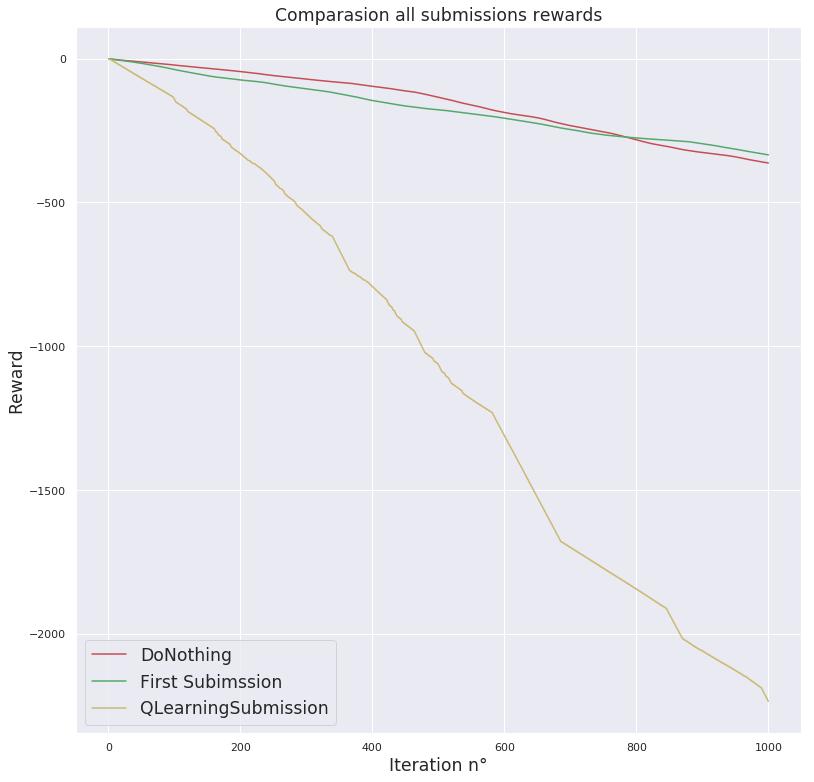

In [22]:
x = np.arange(1,1001)
fig, ax = plt.subplots(1,1,figsize = (13,13))
ax.plot(x,rewList1Cumul, label = "DoNothing", Color = 'r')
ax.plot(x,rewList2Cumul, label = "First Subimssion", Color = 'g')
#ax.plot(x,rewList3Cumul, label = "Second Submission", Color = 'b')
ax.plot(x,rewList5Cumul, label = "QLearningSubmission", Color = 'y')
ax.set_title("Comparasion all submissions rewards", fontsize ="xx-large")
ax.set_xlabel('Iteration n°',fontsize ="xx-large")
ax.set_ylabel('Reward',fontsize ="xx-large")
ax.legend(fontsize ="xx-large", loc = 3)

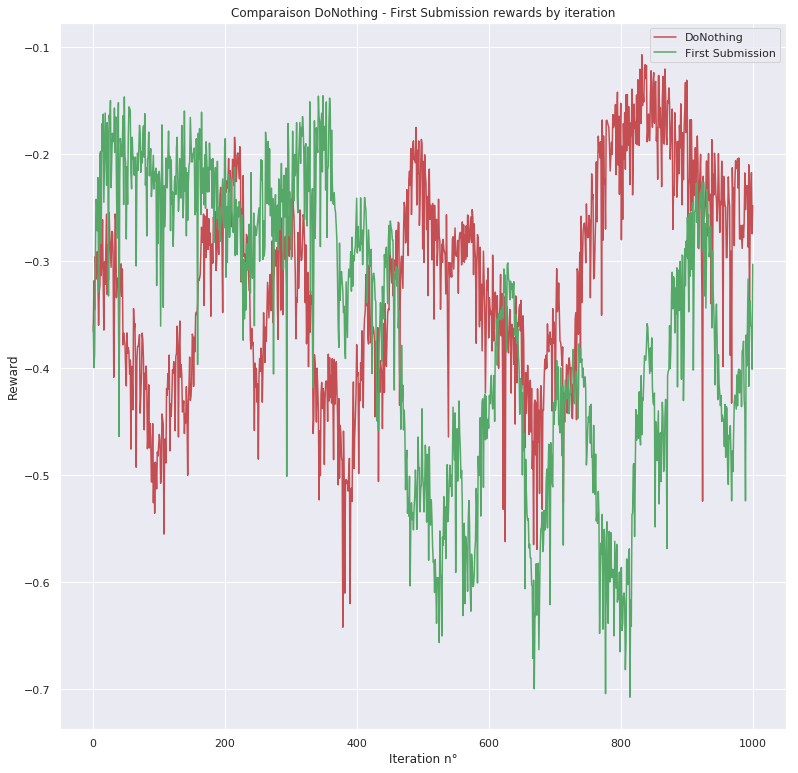

In [23]:
fig, ax = plt.subplots(1,1,figsize = (13,13))
ax.plot(x,rewList1, label = "DoNothing", Color = 'r')
ax.plot(x,rewList2, label = "First Submission", Color = 'g')
ax.set_title("Comparaison DoNothing - First Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

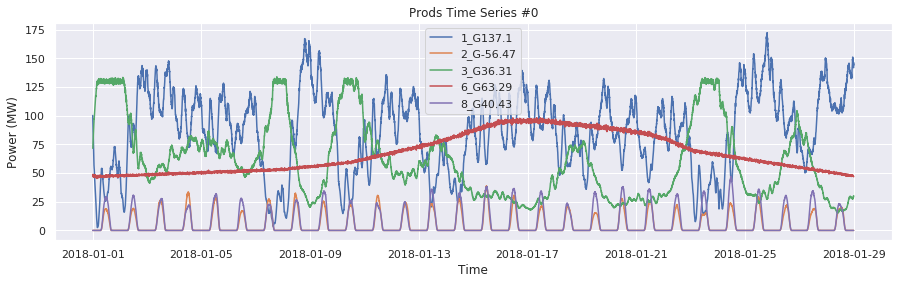

In [25]:
plt.figure(figsize=[15,4])
plt.title('Prods Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_prods_p[str(0)])
plt.legend(list(df_prods_p[str(0)]))
plt.show()

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data_dir = 'public_data/hard'              # Change this to the directory where you put the input data
!ls $data_dir*
loads_p_file = '_N_loads_p.csv'
prods_p_file = '_N_prods_p.csv'
datetimes_file = '_N_datetimes.csv'
maintenance_file = 'maintenance.csv'
hazards_file = 'hazards.csv'
imaps_file = '_N_imaps.csv'
df_loads_p = {}
df_prods_p = {}
df_datetimes = {}
df_maintenance = {}
df_hazards = {} 
i = 0 # chronics id

path = data_dir+'/chronics/'+str(i)+'/'
df_loads_p[str(i)] = pd.read_csv(path+loads_p_file, sep=';')
df_prods_p[str(i)] = pd.read_csv(path+prods_p_file, sep=';')
df_datetimes[str(i)] = pd.read_csv(path+datetimes_file, sep=';')
df_loads_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_prods_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_maintenance[str(i)] = pd.read_csv(path+maintenance_file, sep=';')
df_maintenance[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_hazards[str(i)] = pd.read_csv(path+hazards_file, sep=';')
df_hazards[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_imaps = pd.read_csv(path + imaps_file, sep=';')
print(df_loads_p['0'])

chronics  configuration.yaml  reference_grid.m
                     2_C-10.61  3_C151.15  4_C-9.47  5_C201.84  6_C-6.27  \
2018-01-01 00:00:00       16.9       78.9      38.1        6.2       9.0   
2018-01-01 00:05:00       16.7       80.1      39.0        6.2       8.6   
2018-01-01 00:10:00       16.9       80.4      39.1        6.1       8.8   
2018-01-01 00:15:00       16.9       80.6      38.8        6.1       8.6   
2018-01-01 00:20:00       16.7       78.9      37.8        6.0       8.5   
2018-01-01 00:25:00       16.5       76.8      37.5        6.0       8.6   
2018-01-01 00:30:00       16.6       77.8      37.9        6.0       8.5   
2018-01-01 00:35:00       16.3       78.2      37.0        5.9       8.4   
2018-01-01 00:40:00       16.1       75.6      36.2        5.9       8.4   
2018-01-01 00:45:00       15.9       74.6      36.2        5.8       8.3   
2018-01-01 00:50:00       15.9       75.5      35.7        5.8       8.3   
2018-01-01 00:55:00       15.6       73.7

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (13,13))
ax.plot(x,rewList1Cumul, label = "DoNothing", Color = 'r')
ax.plot(x,rewList2Cumul, label = "First Submission", Color = 'g')
ax.set_title("Comparaison DoNothing - First Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (13,13))
ax.plot(x,rewList1, label = "DoNothing", Color = 'r')
ax.plot(x,rewList3, label = "Second Submission", Color = 'b')
ax.set_title("Comparaison DoNothing - Second Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (13,13))
ax.plot(x,rewList1Cumul, label = "DoNothing", Color = 'r')
ax.plot(x,rewList3Cumul, label = "Second Submission", Color = 'b')
ax.set_title("Comparaison DoNothing - Second Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [ ]:
x = np.arange(1,1001)
fig, ax = plt.subplots(1,1)
ax.plot(x,rewList1)
ax.set_title('DoNothing rewards by iteration')
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(20,15))
ax.plot(x,rewList2)
ax.set_title('First Submission rewards by iteration')
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(x,rewList3)
ax.set_title("Second Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [6]:
a = [1,2,3,4,5]
a[0:2]

[1, 2]